In [319]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict 
import sys
import re
import math

In [320]:
# read file ktotal
df_ktotal = pd.read_csv('ktotal_contratos.csv')
# clean data
### format col names 
df_ktotal.columns = df_ktotal.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_ktotal = df_ktotal[df_ktotal['cct_contract_status_id']!=3]
df_ktotal = df_ktotal[['cct_ctl_id','cct_warranty_start_date', 'cct_contract_source', 'cct_plan_id']]
df_ktotal = df_ktotal.rename(columns={'cct_ctl_id': 'stockid', 'cct_warranty_start_date':'date_delivery', 
                                      'cct_contract_source':'source', 'cct_plan_id':'payment'})
### format date col
df_ktotal['date_delivery'] = pd.to_datetime(df_ktotal['date_delivery'])
### sort, filter by, and format stockid
df_ktotal = df_ktotal.sort_values('date_delivery', ascending=False)
df_ktotal = df_ktotal.drop_duplicates('stockid')
df_ktotal['stockid'] = df_ktotal['stockid'].astype(int)
# examine data
print(df_ktotal.shape)
df_ktotal.head()

(1209, 4)


,stockid,date_delivery,source,payment
617,24631,2020-11-27,2,1
523,26267,2020-11-23,2,1
225,21803,2020-11-23,2,1
552,25917,2020-11-21,2,1
958,21178,2020-11-21,2,1


In [321]:
# read file kcapital
df_kcapital = pd.read_csv("kcapital_contratos.csv")
# clean data
### clean col names
df_kcapital.columns = df_kcapital.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### format date col
df_kcapital['dia_solicitud_aprobada'] = pd.to_datetime(df_kcapital['dia_solicitud_aprobada'], dayfirst=True)
### only include cars with kcapital
df_kcapital =  df_kcapital[df_kcapital['financiamiento_ganado'] == 'Yes']
### select and rename relevant cols
df_kcapital = df_kcapital[['inventory_item','dia_solicitud_aprobada']]
df_kcapital = df_kcapital.rename(columns={'dia_solicitud_aprobada': 'date_approved', 'inventory_item':'stockid'})
### format stockid col
def extr_stockid(auto):
    return re.findall('[\d]+', auto)[0]
df_kcapital['stockid'] = df_kcapital['stockid'].apply(extr_stockid)
df_kcapital['stockid'] = df_kcapital['stockid'].astype(int)
### sort and filter by stockid
df_kcapital = df_kcapital.sort_values('date_approved', ascending=False)
df_kcapital = df_kcapital.drop_duplicates('stockid')
# examine data
print(df_kcapital.shape)
df_kcapital.head()

(920, 2)


,stockid,date_approved
2412,21494,2020-11-18
2408,25439,2020-11-18
2336,20189,2020-11-18
2310,26305,2020-11-17
2099,24069,2020-11-17


In [322]:
# read file entregas
df_entregas = pd.read_csv("entregas.csv")
# clean data
### format col names
df_entregas.columns = df_entregas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_entregas = df_entregas[['estimate_asociado','auto', 'fecha_de_entrega_agendada',
                           'hora', 'responsable_em_venta']]
df_entregas = df_entregas.rename(columns={'estimate_asociado': 'estimate', 'auto':'stockid', 
                                          'fecha_de_entrega_agendada':'date_delivery', 'hora':'hour',
                                          "responsable_em_venta":'salesperson'})
### format, filter by, and sort by date col
df_entregas['date_delivery'] = pd.to_datetime(df_entregas['date_delivery'],  dayfirst=True)
min_date = df_ktotal['date_delivery'].min()
df_entregas = df_entregas[df_entregas['date_delivery'] >= min_date]
df_entregas = df_entregas.sort_values('date_delivery', ascending=False)
### format and filter by stockid col
def extr_stockid(auto):
    return re.findall('[\d]+', auto)[0]
df_entregas['stockid'] = df_entregas['stockid'].apply(extr_stockid)
df_entregas = df_entregas.drop_duplicates('stockid')
### format estimate col
df_entregas['estimate'] = df_entregas['estimate'].str[10:]
# examine data
print(df_entregas.shape)
df_entregas.head()

(8083, 5)


,estimate,stockid,date_delivery,hour,salesperson
12467,2997693,25741,2020-12-03,11:00,Abril Contreras
12466,3190207,20620,2020-11-28,14:00,Herys de Jesús Navarro Castro
12465,3127335,19853,2020-11-27,15:00,Luz Marí­a Lara Mejí­a
12464,2859050,23299,2020-11-27,12:00,Maria Pina
12463,3017611,25299,2020-11-27,12:00,Melanie Carolina Olivares Olivar


In [323]:
# transorm entregas to include hub col
### read em file
ems = pd.read_csv('ems.csv')
### keep and rename relevant cols
ems = ems[['reponsable_em_venta', 'centro_del_em']]
ems = ems.rename(columns={'centro_del_em': 'hub', "reponsable_em_venta":'salesperson'})
### clean name col
for i in range(len(ems)):
    ems.iloc[i] = ems.iloc[i].str.strip()
### match salespeople with hub
hub = ["" for x in range(len(df_entregas))]
for i in range(len(df_entregas)):
    if df_entregas['salesperson'].iloc[i] in list(ems['salesperson'].values):
        indx = list(ems['salesperson'].values).index(df_entregas['salesperson'].iloc[i])
        hub[i] = ems['hub'].iloc[indx]
    else: hub[i] = 'Sin Asignar'
### add hub col
df_entregas['hub'] = hub
print(sum(df_entregas['hub'] == 'Sin asignar'))
df_entregas.head()

27


,estimate,stockid,date_delivery,hour,salesperson,hub
12467,2997693,25741,2020-12-03,11:00,Abril Contreras,Lerma
12466,3190207,20620,2020-11-28,14:00,Herys de Jesús Navarro Castro,San Angel
12465,3127335,19853,2020-11-27,15:00,Luz Marí­a Lara Mejí­a,Tlalpan
12464,2859050,23299,2020-11-27,12:00,Maria Pina,Santa Fe
12463,3017611,25299,2020-11-27,12:00,Melanie Carolina Olivares Olivar,Monterrey


In [324]:
# transform entregas to include ktotal and tradein cols
ktotal = np.zeros(len(df_entregas), dtype=int)
tradein = np.zeros(len(df_entregas), dtype=int)
for i in range(len(df_entregas)):
    if (int(df_entregas['stockid'].iloc[i]) in df_ktotal['stockid'].values):
        ktotal[i] = 1
        indx = list(df_ktotal['stockid'].values).index(int(df_entregas['stockid'].iloc[i]))
        if(df_ktotal['source'].iloc[indx]==3): tradein[i] = 1                                                     
df_entregas['ktotal'] = ktotal
df_entregas['tradein'] = tradein
print(sum(df_entregas['ktotal'] == 1))
print(sum(df_entregas['tradein'] == 1))
df_entregas.head()

1157
160


,estimate,stockid,date_delivery,hour,salesperson,hub,ktotal,tradein
12467,2997693,25741,2020-12-03,11:00,Abril Contreras,Lerma,0,0
12466,3190207,20620,2020-11-28,14:00,Herys de Jesús Navarro Castro,San Angel,0,0
12465,3127335,19853,2020-11-27,15:00,Luz Marí­a Lara Mejí­a,Tlalpan,0,0
12464,2859050,23299,2020-11-27,12:00,Maria Pina,Santa Fe,0,0
12463,3017611,25299,2020-11-27,12:00,Melanie Carolina Olivares Olivar,Monterrey,0,0


In [325]:
# transform entregas to include kcapital col
kcapital = np.zeros(len(df_entregas), dtype=int)
for i in range(len(df_entregas)):
    if (int(df_entregas['stockid'].iloc[i]) in df_kcapital['stockid'].values):
        kcapital[i] = 1
df_entregas['kcapital'] = kcapital
print(sum(df_entregas['kcapital'] == 1))
df_entregas.head()

839


,estimate,stockid,date_delivery,hour,salesperson,hub,ktotal,tradein,kcapital
12467,2997693,25741,2020-12-03,11:00,Abril Contreras,Lerma,0,0,0
12466,3190207,20620,2020-11-28,14:00,Herys de Jesús Navarro Castro,San Angel,0,0,0
12465,3127335,19853,2020-11-27,15:00,Luz Marí­a Lara Mejí­a,Tlalpan,0,0,0
12464,2859050,23299,2020-11-27,12:00,Maria Pina,Santa Fe,0,0,1
12463,3017611,25299,2020-11-27,12:00,Melanie Carolina Olivares Olivar,Monterrey,0,0,0


2020-11-18 00:00:00


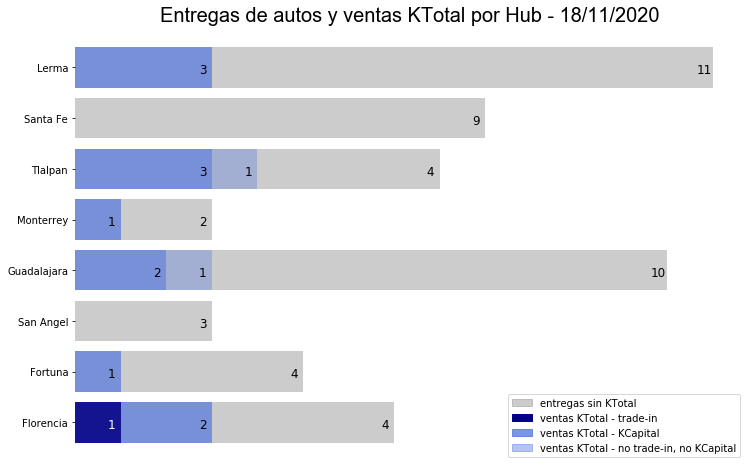

In [327]:
# graph 1: daily stacked bar chart: trade-ins, kcap, no kcap
### find curr date
one_day = timedelta(days=1)
curr_day = pd.to_datetime(datetime.date(datetime.now())-one_day)
print(curr_day)
### filter data for curr day
df_curr_day = df_entregas[df_entregas['date_delivery']==curr_day]
### initialize dics
daily_entregas = {}
daily_ktotal_ti = {}
daily_ktotal_kcap = {}
daily_ktotal_nf = {}
### find daily totals
for hub, frame in df_curr_day.groupby(['hub']):
    daily_entregas[hub] = len(frame)
    count_ti = 0
    count_kcap = 0
    count_nf = 0
    for i in range(len(frame)):
        if(frame['tradein'].iloc[i]==1): count_ti = count_ti+1
        elif(frame['ktotal'].iloc[i]==1): 
            if(frame['kcapital'].iloc[i]==1): count_kcap = count_kcap+1
            else: count_nf = count_nf+1
    daily_ktotal_ti[hub] = count_ti
    daily_ktotal_kcap[hub] = count_kcap
    daily_ktotal_nf[hub] = count_nf
### set x and y values: entregas
daily_entregas.pop('Sin asignar')
x_entr = daily_entregas.keys()
y_entr = daily_entregas.values()
### set x and y values: ktotal (tradein)
daily_ktotal_ti.pop('Sin asignar')
x_ti = daily_ktotal_ti.keys()
y_ti = daily_ktotal_ti.values()
### set x and y values: ktotal (kcapital)
daily_ktotal_kcap.pop('Sin asignar')
x_kcap = daily_ktotal_kcap.keys()
y_kcap = daily_ktotal_kcap.values()
### set x and y values: ktotal (no financiamiento)
daily_ktotal_nf.pop('Sin asignar')
x_nf = daily_ktotal_nf.keys()
y_nf = daily_ktotal_nf.values()
### overlay four barcharts
##### barchart entregas
figure(figsize=(12,8))
bar1 = plt.barh(x_entr, y_entr, alpha=.4, color="gray")
##### barchart ktotal (tradein)
bar2 = plt.barh(x_ti, y_ti, alpha=.9, color="darkblue")
##### barchart ktotal (kcapital)
bar3 = plt.barh(x_kcap, y_kcap, alpha=.6, color="royalblue", left=y_ti)
##### barchart ktotal (no financiamiento)
bar4 = plt.barh(x_nf, y_nf, alpha=.3, color="royalblue", left=y_kcap)
# format title, axes, and legend
titlestr = ('Entregas de autos y ventas KTotal por Hub - ' + curr_day.strftime('%d/%m/%Y'))
plt.title(titlestr, fontsize=20, fontname="Arial")
gray_patch = mpatches.Patch(color='gray', label='entregas sin KTotal', alpha=.4)
lightblue2_patch = mpatches.Patch(color='darkblue', label='ventas KTotal - trade-in', alpha=1)
lightblue3_patch = mpatches.Patch(color='royalblue', label='ventas KTotal - KCapital', alpha=.7, 
                                  edgecolor='white')
lightblue4_patch = mpatches.Patch(color='royalblue', label='ventas KTotal - no trade-in, no KCapital', alpha=.4)
plt.legend(handles=[gray_patch, lightblue2_patch, lightblue3_patch, lightblue4_patch], loc=4)
plt.xticks([])
### label bars
def autolabel1(rects):
    for idx,rect in enumerate(bar1):
        plt.text(y_entr[idx]-.2, rect.get_y()+.35,
                int(y_entr[idx])-int(y_ti[idx])-int(y_kcap[idx])-int(y_nf[idx]), fontsize=12,
                ha='center', va='center', rotation=0)
autolabel1(bar1)
def autolabel2(rects):
    for idx,rect in enumerate(bar2):
        if(y_ti[idx]==0): continue
        plt.text(y_ti[idx]-.2, rect.get_y()+.35,
                int(y_ti[idx]), fontsize=12,
                ha='center', va='center', rotation=0, color="white")
autolabel2(bar2)
def autolabel3(rects):
    for idx,rect in enumerate(bar3):
        if(y_kcap[idx]==0): continue
        plt.text(y_kcap[idx]-.2+y_ti[idx], rect.get_y()+.35,
                int(y_kcap[idx]), fontsize=12,
                ha='center', va='center', rotation=0)
autolabel3(bar3)
def autolabel4(rects):
    for idx,rect in enumerate(bar4):
        if(y_nf[idx]==0): continue
        plt.text(y_nf[idx]-.2+y_kcap[idx]+y_ti[idx], rect.get_y()+.35,
                int(y_nf[idx]), fontsize=12,
                ha='center', va='center', rotation=0)
autolabel4(bar4)
### remove spines and tick marks
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(bottom=False)
plt.savefig('daily_report_notradein.png')  

In [260]:
# deliveries per hour
### find curr day, month, and year
curr_day = datetime.date(datetime.now()).day
curr_month = datetime.date(datetime.now()).month
curr_year = datetime.date(datetime.now()).year
print("Promedio de entregas por hora MTD (" + str(curr_day) + "-" + str(curr_month) + "-" + str(curr_year) + ")")
print("\n")
### filter data by curr month + year
df_month = df_entregas[(df_entregas['date_delivery'].dt.month == curr_month) &
                      (df_entregas['date_delivery'].dt.year == curr_year) &
                      (df_entregas['date_delivery'].dt.day <= curr_day)]
### create day col
df_month['day'] = df_month['date_delivery'].dt.day
### find hourly delivery averages for each hub
for hub, frame in df_month.groupby(['hub']):
    if(hub=='Sin asignar'): continue
    print(hub)
    for hour, frame_hour in frame.groupby(['hour']):
        sumh = float(len(frame_hour))
        days = float(len(set(frame_hour['day'])))
        avg = round(float(sumh/days), 2)
        if(avg != 1): print(hour + ": " + str(avg)) 
        else: continue
    print("\n")

Promedio de entregas por hora MTD (19-11-2020)


Central
12:00: 1.5


Constituyentes


Florencia
10:00: 1.14
12:00: 2.0
15:00: 1.14
16:00: 1.33
16:15: 1.25
17:00: 1.11


Fortuna
10:00: 1.4
11:00: 1.2
12:00: 1.2
13:00: 1.5
15:00: 1.2
16:00: 1.43
17:00: 1.33
20:00: 1.33


Guadalajara
10:00: 1.75
11:00: 1.45
12:00: 1.33
14:00: 1.17
15:00: 1.33
16:00: 1.43
17:00: 1.43
18:00: 1.33
21:30: 2.0


Lerma
10:00: 1.5
11:00: 2.07
12:00: 2.6
13:00: 1.77
13:30: 1.2
14:00: 1.58
15:00: 1.69
16:00: 2.08
17:00: 1.69
18:00: 1.25
19:00: 1.33
20:00: 1.25
22:00: 2.0
9:00: 2.0
9:30: 1.25


Monterrey
10:30: 2.0


/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


12:00: 1.5
14:30: 1.33
17:00: 1.25
17:30: 2.0


Puebla
12:00: 2.0


San Angel
14:00: 1.5
15:00: 1.5
17:00: 1.2


Santa Fe
10:00: 1.17
11:00: 1.63
12:00: 1.33
13:00: 1.5
14:00: 1.5
15:00: 1.6
16:00: 1.67
17:00: 1.5


Sin Asignar


Tlalpan
12:00: 1.14
16:00: 1.4
17:00: 1.4
17:30: 1.2
18:00: 2.0


